In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import os
from pathlib import Path

In [3]:
# Constants
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 30
SHUFFLE_SIZE = 10000

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Check and extract dataset
ZIP_FILE = "/content/drive/MyDrive/datasets/PlantVillage.zip"
EXTRACT_PATH = Path("datasets")

In [5]:
if os.path.exists(ZIP_FILE):
    print(f"Found zip file at: {ZIP_FILE}")
    with zipfile.ZipFile(ZIP_FILE, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)
    print("Extracted folder contents:", os.listdir(EXTRACT_PATH))
    class_folders = os.listdir(EXTRACT_PATH / "PlantVillage")
    print("Class folders:", class_folders)
else:
    print(f"Error: Zip file not found at {ZIP_FILE}")
    print("Please check the path. Make sure:")
    print("1. Google Drive is mounted")
    print("2. The file exists in /content/drive/MyDrive/datasets/PlantVillage.zip")
    print("3. The file name is spelled correctly")

    exit(1)

Found zip file at: /content/drive/MyDrive/datasets/PlantVillage.zip
Extracted folder contents: ['PlantVillage']
Class folders: ['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_healthy']


In [6]:
# Load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    EXTRACT_PATH / "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5452 files belonging to 4 classes.


In [7]:
class_names = dataset.class_names
n_classes = len(class_names)
print("Class names:", class_names)

Class names: ['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_healthy']


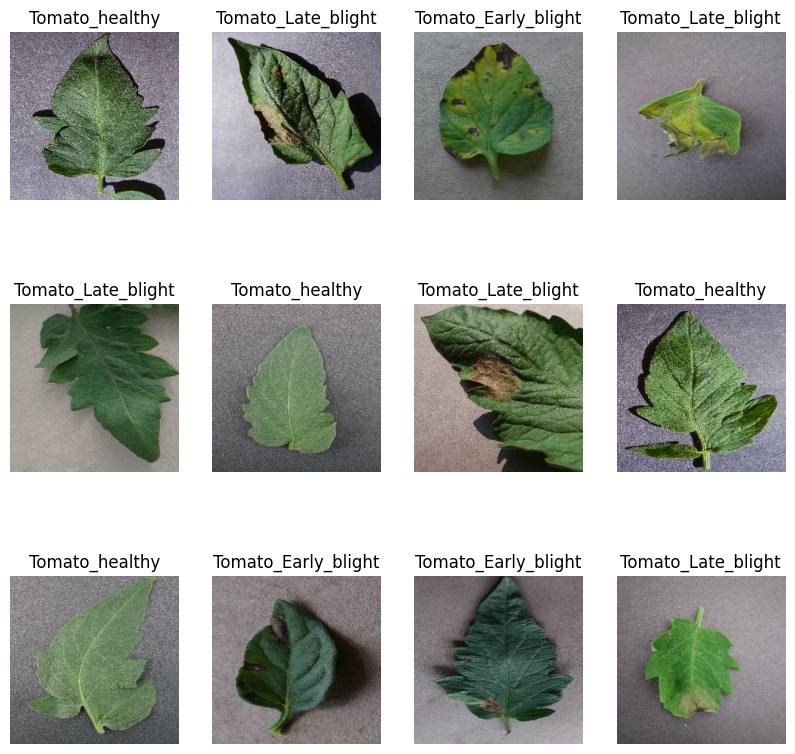

In [8]:
# Visualize sample images
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")
plt.show()

In [9]:
# Split dataset
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [11]:
# Preprocessing and augmentation
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

In [12]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1)
])

In [12]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
# Optimize dataset performance
train_ds = train_ds.cache().shuffle(SHUFFLE_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
# Build model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = models.Sequential([
    layers.Input(shape=input_shape),
    resize_and_rescale,
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax')
])

In [15]:
# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [16]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 175,940 (687.27 KB)

 Trainable params: 175,940 (687.27 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Callbacks
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') >= 0.97:
            print(f"\nStopping training as validation accuracy reached {logs.get('val_accuracy'):.2f}")
            self.model.stop_training = True

In [19]:
custom_callback = CustomCallback()

In [20]:
# Train model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=[custom_callback]
)

Epoch 1/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 24s 75ms/step - accuracy: 0.3762 - loss: 1.3112 - val_accuracy: 0.5827 - val_loss: 0.9436
Epoch 2/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.6198 - loss: 0.8706 - val_accuracy: 0.7500 - val_loss: 0.6308
Epoch 3/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.7300 - loss: 0.6629 - val_accuracy: 0.8070 - val_loss: 0.5200
Epoch 4/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.7633 - loss: 0.5711 - val_accuracy: 0.8125 - val_loss: 0.4796
Epoch 5/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.8046 - loss: 0.5197 - val_accuracy: 0.8309 - val_loss: 0.4461
Epoch 6/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.8253 - loss: 0.4454 - val_accuracy: 0.8787 - val_loss: 0.3562
Epoch 7/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.8616 - loss: 0.3742 - val_accuracy: 0.8456 - val_loss: 0.3651
Epoch 8/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.8842 - loss: 0.3053 - val_

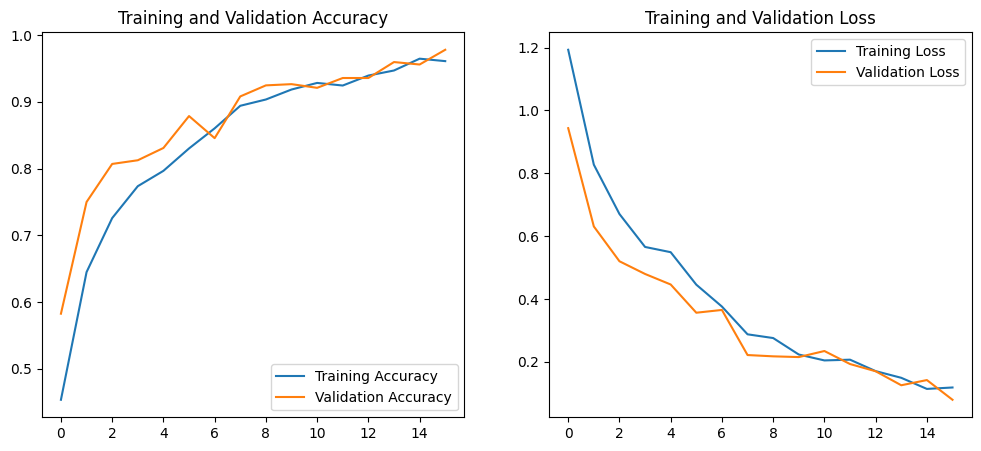

In [21]:
# Plot training results
epochs_range = range(len(history.history['accuracy']))
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.show()

In [22]:
# Prediction function
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array, verbose=0)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence

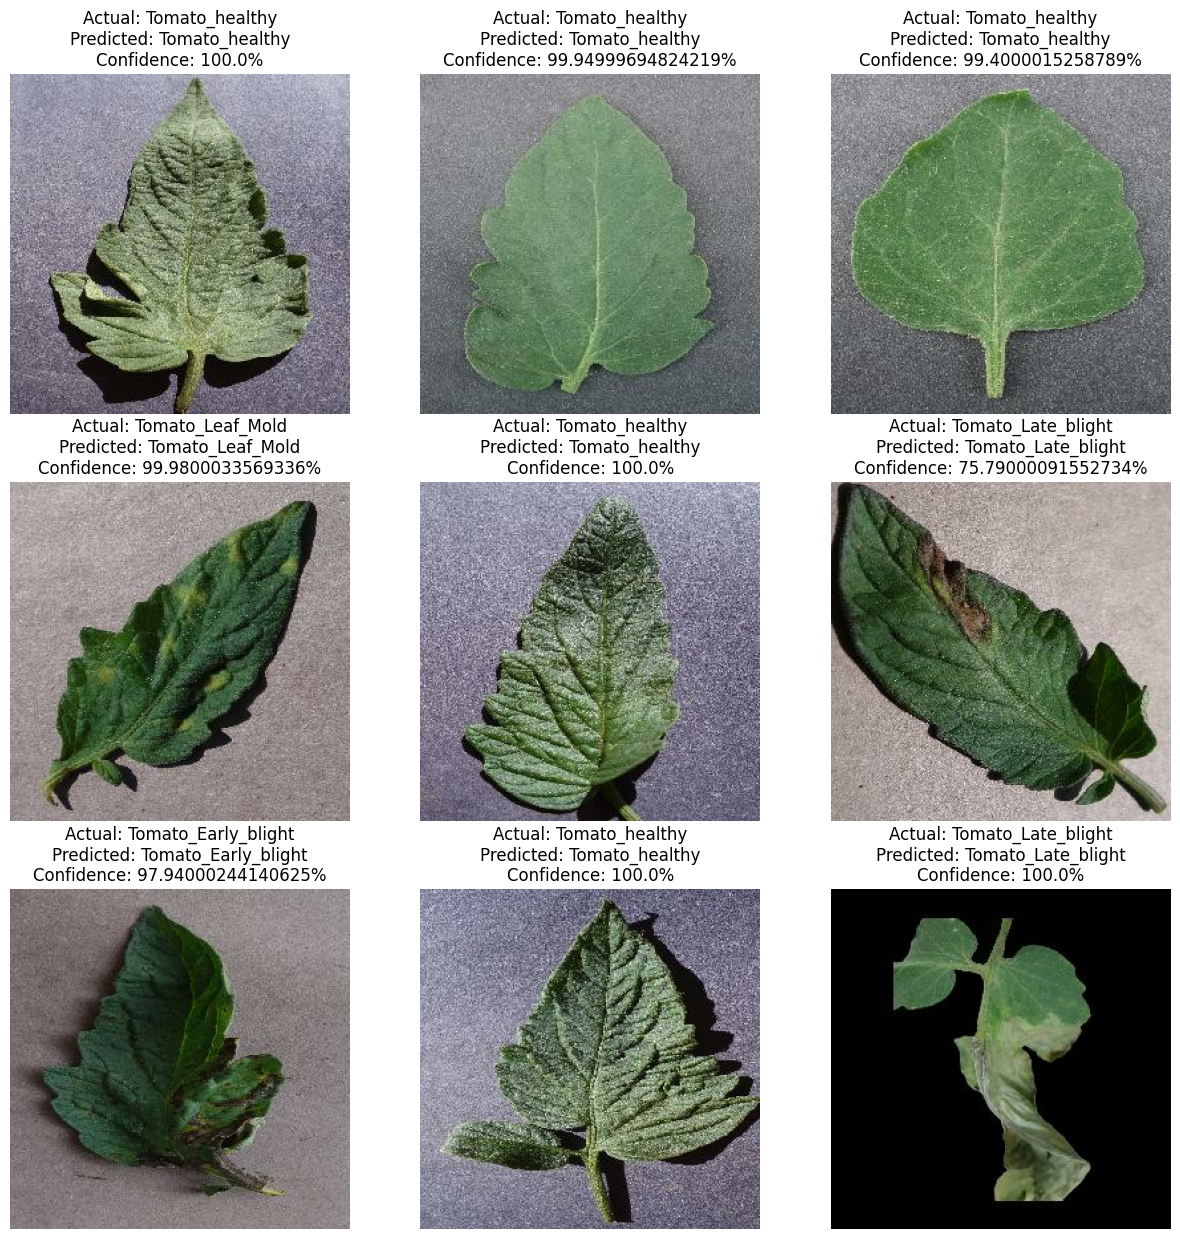

In [24]:
# Evaluate on test set
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow((images[i].numpy()).astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
        plt.axis("off")
plt.show()

In [25]:
# Save model
model.save('tomato_disease_classifier.keras')
print("Model saved as tomato_disease_classifier.keras")

Model saved as tomato_disease_classifier.keras
